# Desafio 1: Análise da Dinâmica Temporal e Geográfica dos Preços de Combustíveis

Joab Morais Varela

### Objetivo
Conduzir uma Análise Exploratória de Dados (EDA) para gerar de 3 a 5 insights  
acionáveis sobre a dinâmica de preços de combustíveis no Brasil, considerando  
variações temporais e geográficas (Unidade Federativa e Região), a partir de dados  
públicos da ANP.  

## Importando bibliotecas

In [71]:
import os
import kagglehub
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm  # Para gerenciar as cores
import matplotlib.dates as mdates # Para formatar o eixo de data
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose # Para decomposição

## Carregando dados

In [72]:
df = pd.read_csv('DATA/2004-2021.tsv', sep='\t')
df.head()

,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133
1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115
2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.18,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098
3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.09,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143
4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.05,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082


## Análise da Qualidade dos Dados

A análise do output ``df.head()`` permite constatar que o dataset é composto por variáveis (features) de diversos tipos de dados, a saber: temporais ``date``, de ponto flutuante ``float``, inteiras ``int`` e textuais ``str``. Entretanto, a saída da função ``df.info()`` indica que a tipagem automática das variáveis não corresponde ao formato mais adequado para sua análise e manipulação. Sendo assim, o primeiro passo metodológico será a conversão e atribuição dos tipos de dados apropriados a cada feature.

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120823 entries, 0 to 120822
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   DATA INICIAL                   120823 non-null  object 
 1   DATA FINAL                     120823 non-null  object 
 2   REGIÃO                         120823 non-null  object 
 3   ESTADO                         120823 non-null  object 
 4   PRODUTO                        120823 non-null  object 
 5   NÚMERO DE POSTOS PESQUISADOS   120823 non-null  int64  
 6   UNIDADE DE MEDIDA              120823 non-null  object 
 7   PREÇO MÉDIO REVENDA            120823 non-null  float64
 8   DESVIO PADRÃO REVENDA          120823 non-null  float64
 9   PREÇO MÍNIMO REVENDA           120823 non-null  float64
 10  PREÇO MÁXIMO REVENDA           120823 non-null  float64
 11  MARGEM MÉDIA REVENDA           120823 non-null  object 
 12  COEF DE VARIAÇÃO REVENDA      

Nesta etapa do pré-processamento, serão tratadas questões referentes à tipificação adequada dos dados, à identificação e tratamento de valores ausentes e duplicados, bem como à verificação da coerência e consistência das classes presentes no conjunto de dados.

Lista de tarefas:

- Tipagem das colunas referentes a datas
- Tipagem das colunas referentes a valores numéricos
- tipagem das colunas referentes a valores categóricos

In [74]:
# Tipagem das colunas referentes a datas
df[['DATA INICIAL','DATA FINAL']] = df[['DATA INICIAL','DATA FINAL']].apply(pd.to_datetime)

De acordo com a documentação da fonte de dados (Kaggle), os valores ausentes (NULL) foram codificados artificialmente no conjunto de dados como o valor ``-99999``.

In [75]:
# Para automatizar o processo vamos identificar todas as colunas numéricas e em seguida utilizar para iterar um loop. Com isso tbm iremos resolver o problema do tipo de 
# algumas colunas numéricas que estão descritas como objeto.

numeric_cols = [
    'PREÇO MÉDIO REVENDA', 'DESVIO PADRÃO REVENDA', 'PREÇO MÍNIMO REVENDA', 
    'PREÇO MÁXIMO REVENDA', 'MARGEM MÉDIA REVENDA', 'COEF DE VARIAÇÃO REVENDA',
    'PREÇO MÉDIO DISTRIBUIÇÃO', 'DESVIO PADRÃO DISTRIBUIÇÃO', 
    'PREÇO MÍNIMO DISTRIBUIÇÃO', 'PREÇO MÁXIMO DISTRIBUIÇÃO', 
    'COEF DE VARIAÇÃO DISTRIBUIÇÃO'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].replace(-99999.0, np.nan)

# Verificando a quantidade de valores nulos

print(f'Quântidade de valores nulos:\n{df.isnull().sum()}')

Quântidade de valores nulos:
DATA INICIAL                        0
DATA FINAL                          0
REGIÃO                              0
ESTADO                              0
PRODUTO                             0
NÚMERO DE POSTOS PESQUISADOS        0
UNIDADE DE MEDIDA                   0
PREÇO MÉDIO REVENDA                 0
DESVIO PADRÃO REVENDA               0
PREÇO MÍNIMO REVENDA                0
PREÇO MÁXIMO REVENDA                0
MARGEM MÉDIA REVENDA             8948
COEF DE VARIAÇÃO REVENDA            0
PREÇO MÉDIO DISTRIBUIÇÃO         8908
DESVIO PADRÃO DISTRIBUIÇÃO       8908
PREÇO MÍNIMO DISTRIBUIÇÃO        8908
PREÇO MÁXIMO DISTRIBUIÇÃO        8908
COEF DE VARIAÇÃO DISTRIBUIÇÃO    8908
dtype: int64


Agora vamos verificar se temos problemas nas colunas de categorias

In [76]:
# Agora é a vez de verificar os valores únicos em colunas categóricas

print("\nValores únicos em 'PRODUTO':")
print(df['PRODUTO'].unique())

print("\nValores únicos em 'UNIDADE DE MEDIDA':")
print(df['UNIDADE DE MEDIDA'].unique())


Valores únicos em 'PRODUTO':
['ETANOL HIDRATADO' 'GASOLINA COMUM' 'GLP' 'GNV' 'ÓLEO DIESEL'
 'ÓLEO DIESEL S10' 'OLEO DIESEL' 'OLEO DIESEL S10' 'GASOLINA ADITIVADA']

Valores únicos em 'UNIDADE DE MEDIDA':
['R$/l' 'R$/13Kg' 'R$/m3']


É possivel observar uma inconsistência na codificação textual da variável categórica referente aos tipos de combustível, especificamente a variação na grafia entre ``'ÓLEO DIESEL'`` e ``'OLEO DIESEL'``, e similarmente entre ``'ÓLEO DIESEL S10'`` e ``'OLEO DIESEL S10'``.

In [77]:
df['PRODUTO'] = df['PRODUTO'].str.replace('Ó', 'O')

print("\nValores únicos em 'PRODUTO':")
print(df['PRODUTO'].unique())


Valores únicos em 'PRODUTO':
['ETANOL HIDRATADO' 'GASOLINA COMUM' 'GLP' 'GNV' 'OLEO DIESEL'
 'OLEO DIESEL S10' 'GASOLINA ADITIVADA']


Agora vamos verificar se existe linhas duplicadas no nosso dataset, se sim, remover a dupla

In [78]:
# Verificando linhas duplicadas

numero_de_linhas_duplicadas = df.duplicated().sum()
print(f"\nNúmero de linhas duplicadas: {numero_de_linhas_duplicadas}")

# Se houver duplicatas, podemos removê-las

if numero_de_linhas_duplicadas > 0:
    df.drop_duplicates(inplace=True)


Número de linhas duplicadas: 0


Verificando se Possui alguma região ou estados repetidos

In [79]:
print('As regiões unicas são:\n')
print(df['REGIÃO'].unique())
print('Que correspondem as 5 regiões do Brasil corretamente\n')

print('Os estados unicos são:\n')
print(df['ESTADO'].unique())
print(f'Que correspondem aos {len(df['ESTADO'].unique())} estados do Brasil corretamente')


As regiões unicas são:

['CENTRO OESTE' 'NORDESTE' 'NORTE' 'SUDESTE' 'SUL']
Que correspondem as 5 regiões do Brasil corretamente

Os estados unicos são:

['DISTRITO FEDERAL' 'GOIAS' 'MATO GROSSO' 'MATO GROSSO DO SUL' 'ALAGOAS'
 'BAHIA' 'CEARA' 'MARANHAO' 'PARAIBA' 'PERNAMBUCO' 'PIAUI'
 'RIO GRANDE DO NORTE' 'SERGIPE' 'ACRE' 'AMAPA' 'AMAZONAS' 'PARA'
 'RONDONIA' 'RORAIMA' 'TOCANTINS' 'ESPIRITO SANTO' 'MINAS GERAIS'
 'RIO DE JANEIRO' 'SAO PAULO' 'PARANA' 'RIO GRANDE DO SUL'
 'SANTA CATARINA']
Que correspondem aos 27 estados do Brasil corretamente


Outra pergunta que podemos fazer é se cada região engloba corretamente os estados

In [80]:
combinacoes_unicas = df[['ESTADO', 'REGIÃO']].drop_duplicates()
combinacoes_unicas


,ESTADO,REGIÃO
0,DISTRITO FEDERAL,CENTRO OESTE
1,GOIAS,CENTRO OESTE
2,MATO GROSSO,CENTRO OESTE
3,MATO GROSSO DO SUL,CENTRO OESTE
4,ALAGOAS,NORDESTE
5,BAHIA,NORDESTE
6,CEARA,NORDESTE
7,MARANHAO,NORDESTE
8,PARAIBA,NORDESTE
9,PERNAMBUCO,NORDESTE


Por fim, vamos verificar as colunas que ainda são descritas como um objeto genérico:

In [81]:
colunas_objeto = df.select_dtypes(include='object').columns
colunas_objeto
# Sobraram apenas as colunas categoricas

Index(['REGIÃO', 'ESTADO', 'PRODUTO', 'UNIDADE DE MEDIDA'], dtype='object')

In [82]:
#df[colunas_objeto] = df[colunas_objeto].astype('category')

uma útima verificação

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120823 entries, 0 to 120822
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   DATA INICIAL                   120823 non-null  datetime64[ns]
 1   DATA FINAL                     120823 non-null  datetime64[ns]
 2   REGIÃO                         120823 non-null  object        
 3   ESTADO                         120823 non-null  object        
 4   PRODUTO                        120823 non-null  object        
 5   NÚMERO DE POSTOS PESQUISADOS   120823 non-null  int64         
 6   UNIDADE DE MEDIDA              120823 non-null  object        
 7   PREÇO MÉDIO REVENDA            120823 non-null  float64       
 8   DESVIO PADRÃO REVENDA          120823 non-null  float64       
 9   PREÇO MÍNIMO REVENDA           120823 non-null  float64       
 10  PREÇO MÁXIMO REVENDA           120823 non-null  float64       
 11  

### Para os outlaiers

In [84]:
coluna_de_preco = 'PREÇO MÉDIO REVENDA'

# Remover linhas onde não temos preço ou unidade de medida (Verificação extra)
df_clean = df.dropna(subset=[coluna_de_preco, 'UNIDADE DE MEDIDA'])

# Criar os dataframes filtrados para cada unidade
df_l = df_clean[df_clean['UNIDADE DE MEDIDA'] == 'R$/l']
df_m3 = df_clean[df_clean['UNIDADE DE MEDIDA'] == 'R$/m3']
df_13kg = df_clean[df_clean['UNIDADE DE MEDIDA'] == 'R$/13Kg']

C:\Users\joabm\AppData\Local\Temp\ipykernel_14328\909714955.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax_l, data=df_l, x='PRODUTO', y=coluna_de_preco, palette="coolwarm")
C:\Users\joabm\AppData\Local\Temp\ipykernel_14328\909714955.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax_m3, data=df_m3, x='PRODUTO', y=coluna_de_preco, palette="viridis")
C:\Users\joabm\AppData\Local\Temp\ipykernel_14328\909714955.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax_13kg, data=df_13kg, x='PRODUTO', y=coluna_de_preco, palet

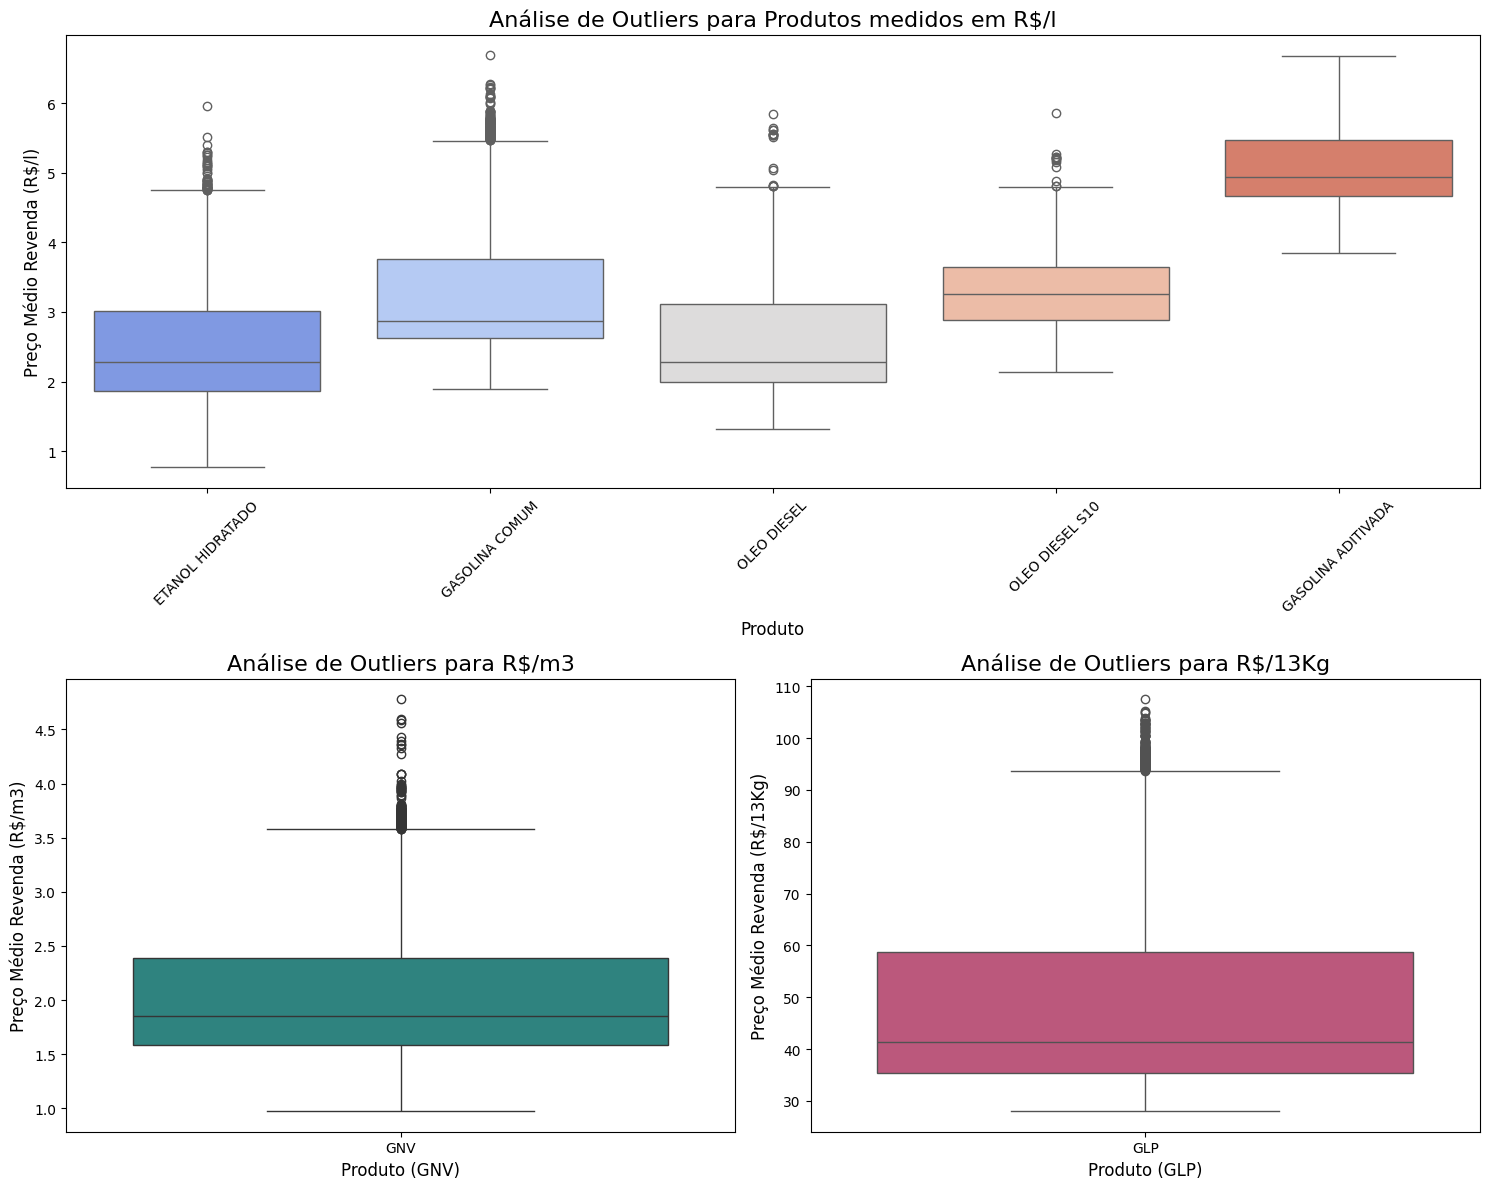

In [85]:
# defifindo figura e tamanho junto com o grid
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 2, figure=fig)

# Definindo subplots
ax_l = fig.add_subplot(gs[0, :])
ax_m3 = fig.add_subplot(gs[1, 0])
ax_13kg = fig.add_subplot(gs[1, 1])

sns.boxplot(ax=ax_l, data=df_l, x='PRODUTO', y=coluna_de_preco, palette="coolwarm")
ax_l.set_title(f'Análise de Outliers para Produtos medidos em R$/l', fontsize=16)
ax_l.set_xlabel('Produto', fontsize=12)
ax_l.set_ylabel('Preço Médio Revenda (R$/l)', fontsize=12)
ax_l.tick_params(axis='x', rotation=45) # Rotacionar labels (são muitos)

sns.boxplot(ax=ax_m3, data=df_m3, x='PRODUTO', y=coluna_de_preco, palette="viridis")
ax_m3.set_title(f'Análise de Outliers para R$/m3', fontsize=16)
ax_m3.set_xlabel('Produto (GNV)', fontsize=12)
ax_m3.set_ylabel('Preço Médio Revenda (R$/m3)', fontsize=12)

sns.boxplot(ax=ax_13kg, data=df_13kg, x='PRODUTO', y=coluna_de_preco, palette="plasma")
ax_13kg.set_title(f'Análise de Outliers para R$/13Kg', fontsize=16)
ax_13kg.set_xlabel('Produto (GLP)', fontsize=12)
ax_13kg.set_ylabel('Preço Médio Revenda (R$/13Kg)', fontsize=12)

plt.tight_layout()

# Para salvar, descomente abaixo
#output_filename = 'analise_outliers_layout_custom.png'
#plt.savefig(output_filename)


À primeira vista, a expressiva presença de outliers nos valores do preço médio poderia suscitar dúvidas quanto à integridade dos dados.  
No entanto, a análise dos boxplots revela que a distribuição de preços para cada produto mantém-se, em geral, coerente e bem estruturada,  
apresentando apenas uma assimetria positiva (cauda superior alongada). Tal comportamento é consistente com as variações esperadas  
decorrentes de fatores como inflação, custos logísticos e diferenças regionais. Um aspecto que reforça essa interpretação é a ausência de  
outliers na extremidade inferior das distribuições, indicando que os desvios observados concentram-se predominantemente em valores acima da média. 

## Análise Temporal

Para a análise temporal, não será necessário utilizar todas as variáveis disponíveis. Assim, será construído um conjunto de dados reduzido,  
contendo apenas as informações essenciais para esse tipo de investigação.

Inicialmente, será examinada a tendência de longo prazo dos preços, o que pode ser realizado a partir das médias nacional,  
regional ou estadual. Para tanto, emprega-se o método ``groupby`` em conjunto com a função ``mean()``, a fim de agregar e  
estruturar os dados de acordo com o nível de análise desejado.

In [86]:
df_clean = df.dropna(subset=[coluna_de_preco, 'DATA FINAL', 'PRODUTO', 'UNIDADE DE MEDIDA']) # novamente uma verificação extra para as novas colunas
# Calcular o preço médio nacional (média dos estados) por produto, por data
df_temporal_nacional = df_clean.groupby(['DATA FINAL', 'PRODUTO', 'UNIDADE DE MEDIDA'])[coluna_de_preco].mean().reset_index()

In [87]:
# Pivotando a tabela para o formato ideal: Index = Data, Colunas = Produtos
# Por questão de simplicidade vamos analisar apenas os produtos R$/l primeiro
df_pivot_l = df_temporal_nacional[df_temporal_nacional['UNIDADE DE MEDIDA'] == 'R$/l'].pivot(
    index='DATA FINAL', 
    columns='PRODUTO', 
    values=coluna_de_preco
)

print("Dados pivotados (R$/l):")
print(df_pivot_l.tail())

Dados pivotados (R$/l):
PRODUTO     ETANOL HIDRATADO  GASOLINA ADITIVADA  GASOLINA COMUM  OLEO DIESEL  \
DATA FINAL                                                                      
2021-04-03          4.506037            5.647704        5.503593     4.361889   
2021-04-10          4.437704            5.647185        5.499778     4.341444   
2021-04-17          4.399741            5.634407        5.479296     4.318111   
2021-04-24          4.417630            5.670538        5.493333     4.332593   
2021-05-01          4.440778            5.642630        5.500000     4.306037   

PRODUTO     OLEO DIESEL S10  
DATA FINAL                   
2021-04-03         4.414519  
2021-04-10         4.391444  
2021-04-17         4.373889  
2021-04-24         4.380222  
2021-05-01         4.363778  


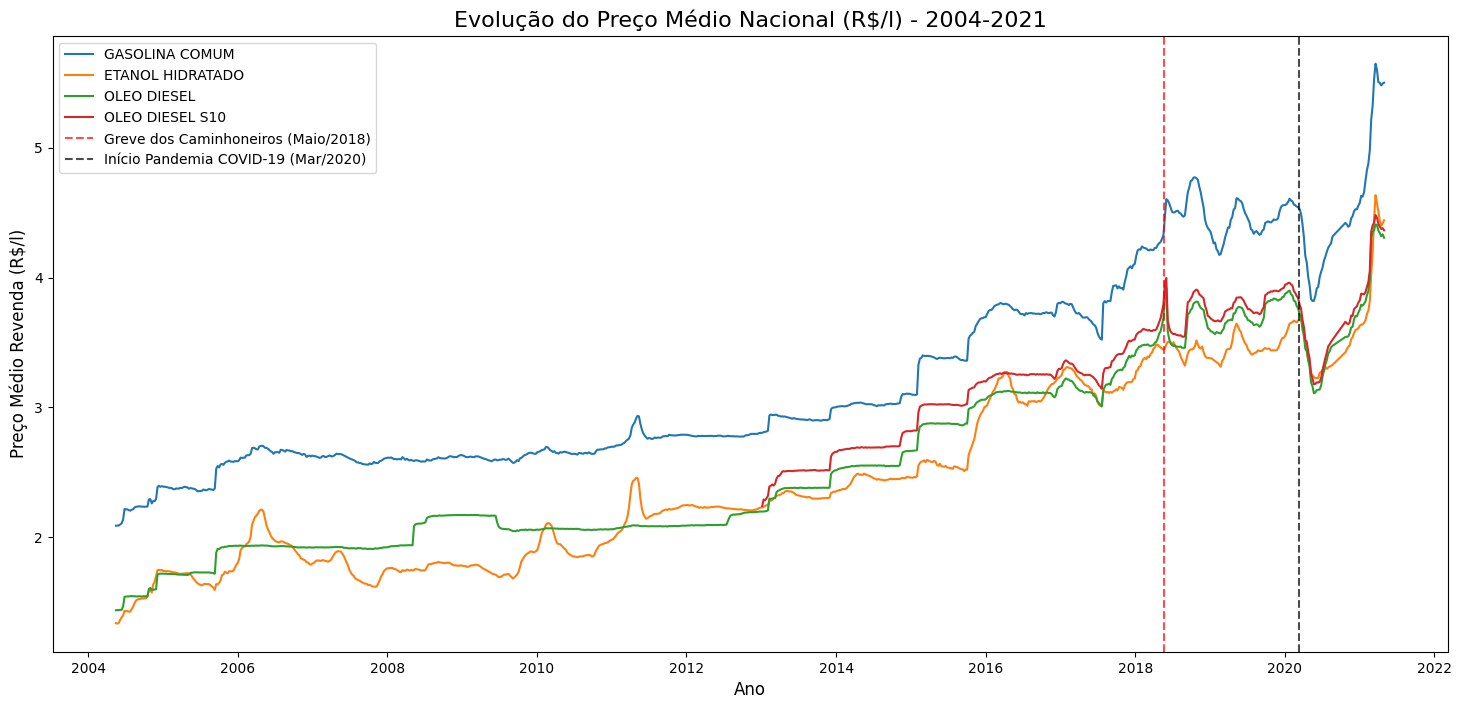

In [88]:
# listando apenas produtos com (R$/l)
produtos_l = ['GASOLINA COMUM','ETANOL HIDRATADO','OLEO DIESEL','OLEO DIESEL S10']

# Plot
plt.figure(figsize=(18, 8))
for produto in produtos_l:
    if produto in df_pivot_l.columns:
        plt.plot(df_pivot_l.index, df_pivot_l[produto], label=produto)

plt.title('Evolução do Preço Médio Nacional (R$/l) - 2004-2021', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Preço Médio Revenda (R$/l)', fontsize=12)
plt.legend(fontsize=12)

# Adicionar linhas verticais para eventos notáveis que tenderam a picos ou quedas abruptas na tendencia temporal
plt.axvline(pd.to_datetime('2018-05-21'), color='red', linestyle='--', alpha=0.7, label='Greve dos Caminhoneiros (Maio/2018)')
plt.axvline(pd.to_datetime('2020-03-11'), color='black', linestyle='--', alpha=0.7, label='Início Pandemia COVID-19 (Mar/2020)')
plt.legend()
plt.show()

Com esta análise, podemos identificar algumas características:

* Tendência geral das curvas: Todos os combustíveis apresentam uma forte tendência de aumento de preço no longo prazo. Essa elevação pode estar relacionada a fatores como inflação, custos de produção e dinâmicas nas relações internacionais.

* Eventos externos: É possível observar diversas variações locais abruptas, que podem ou não estar associadas a eventos externos. No gráfico, são destacados dois casos em que eventos dessa natureza interferiram diretamente na tendência local dos preços.

* Sazonalidade: Este é o ponto mais difícil de identificar. Podemos forçar um pouco e dizer que observamos uma leve subida no início de cada ano. Contudo, uma análise precisa para este ponto é necessária. (Este é o caso do próximo exemplo, onde utilizamos o etanol.)

C:\Users\joabm\AppData\Local\Temp\ipykernel_14328\1180017317.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_mensal.index, y=media_mensal.values, palette='viridis')


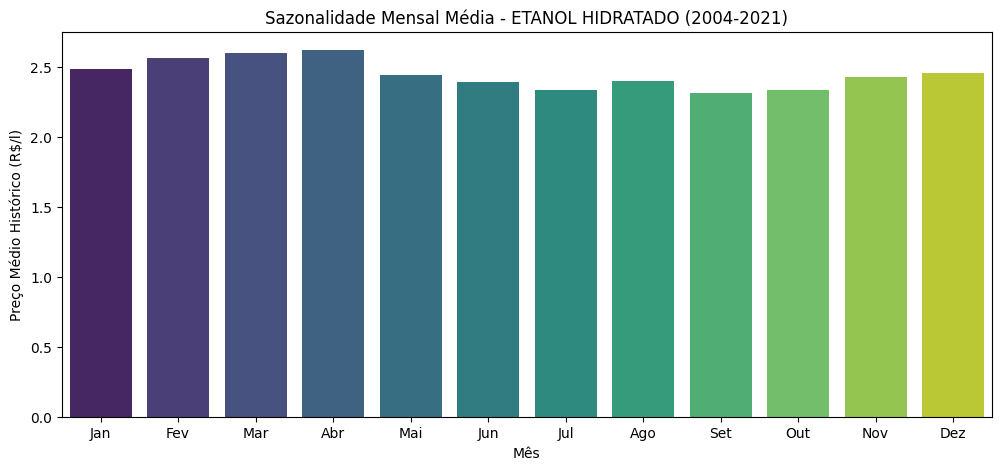

In [89]:
# Utilizando apenas o ETANOL, que é sazonal devido à safra da cana-de-açúcar.
df_etanol = df_pivot_l[['ETANOL HIDRATADO']].dropna().copy()

# Criando coluna de Mês para facilitar
df_etanol['MES'] = df_etanol.index.month
df_etanol['ANO'] = df_etanol.index.year

# Calculando a média de preço para cada mês ao longo de todos os anos
media_mensal = df_etanol.groupby('MES')['ETANOL HIDRATADO'].mean()

# Plot da sazonalidade
plt.figure(figsize=(12, 5))
sns.barplot(x=media_mensal.index, y=media_mensal.values, palette='viridis')
plt.title('Sazonalidade Mensal Média - ETANOL HIDRATADO (2004-2021)')
plt.xlabel('Mês')
plt.ylabel('Preço Médio Histórico (R$/l)')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.show()

C:\Users\joabm\AppData\Local\Temp\ipykernel_14328\741946713.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_etanol, x='MES', y='ETANOL HIDRATADO', palette='viridis')


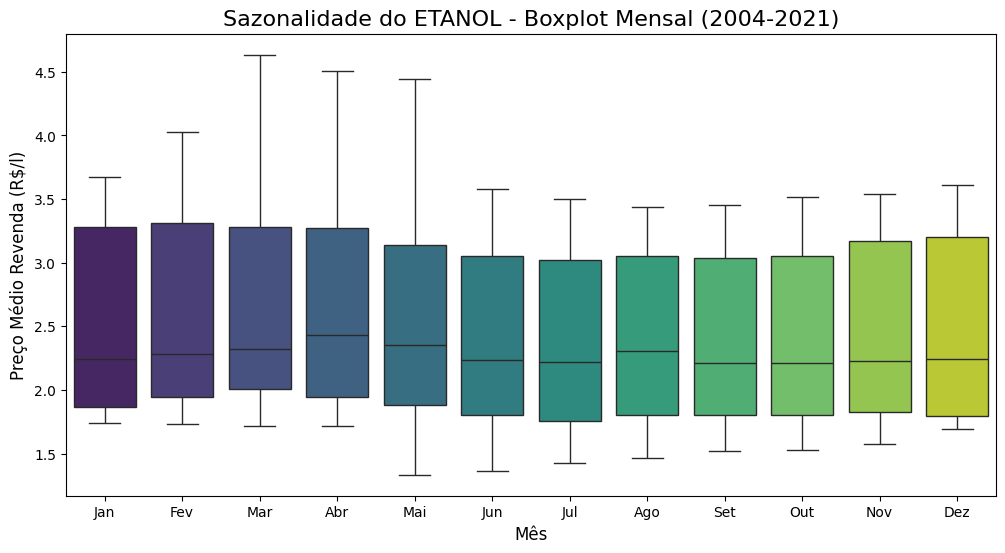

In [90]:
# Criando um boxplot
# Isso mostra a distribuição dos preços para cada mês, ao longo de todos os anos
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_etanol, x='MES', y='ETANOL HIDRATADO', palette='viridis')
plt.title('Sazonalidade do ETANOL - Boxplot Mensal (2004-2021)', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Preço Médio Revenda (R$/l)', fontsize=12)
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.show()

Para observar a sazonalidade, escolhi o etanol, já que ele depende de matéria-prima sazonal para produção. Tanto o Bar Plot quanto o Box Plot apresentam a mesma tendência sazonal, confirmando o esperado.

Pode-se tentar encontrar periodicidade nos dados utilizando alguma ferramenta para esse fim, como uma Transformada de Fourier ou alguma transformada que identifique frequências.
Para esta tarefa vamos utilizar uma ferramenta simples que faz a decomposição clássica da série temporal, que é a ``seasonal_decompose`` da ``statsmodels.tsa.seasonal``.

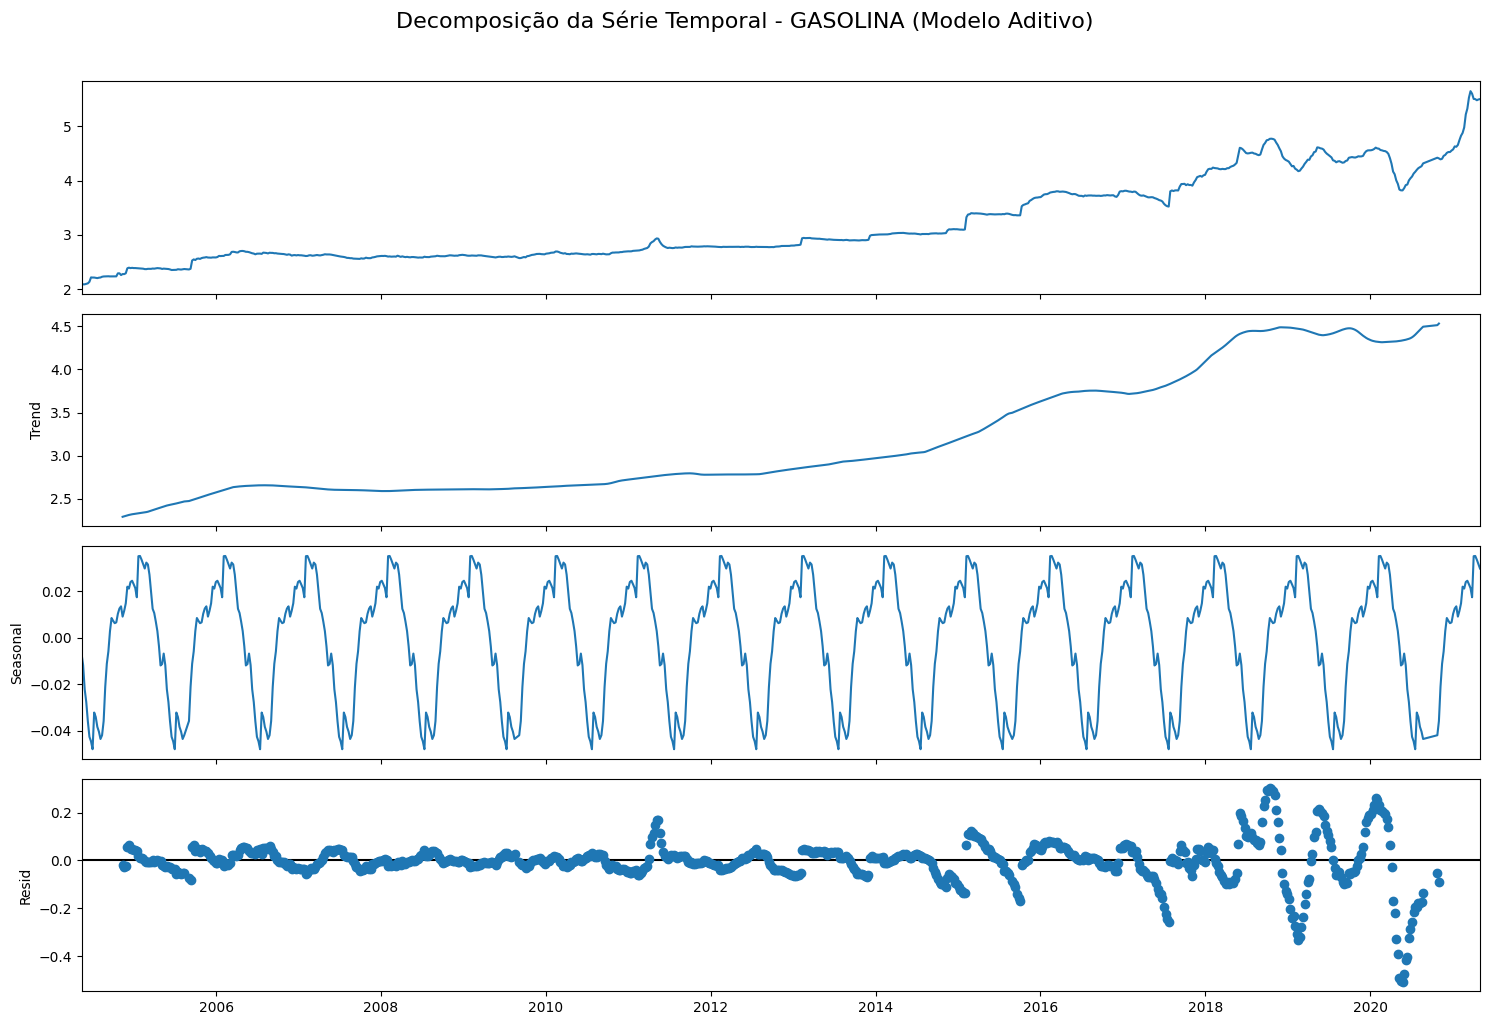

In [91]:
df_gasolina = df_pivot_l[['GASOLINA COMUM']].dropna()

# O seasonal_decompose precisa de um período (frequência)
# Como são dados semanais, um ciclo anual tem aprox. 52 semanas
# Usamos 'additive' assumindo que a sazonalidade é constante
decomposicao = seasonal_decompose(df_gasolina, model='additive', period=52)

# Plot
fig = decomposicao.plot()
fig.set_size_inches(15, 10)
plt.suptitle('Decomposição da Série Temporal - GASOLINA (Modelo Aditivo)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

O plot superior é a evolução do preço nacional da gasolina, já plotado anteriormente. O plot ``Trend`` mostra a tendência da evolução. ``Seasonal`` mostra a sazonalidade no período de 52 semanas, referente a 1 ano. Ao removermos a tendência e a sazonalidade, temos o ``Resid``, Resíduo.

Um caso interessante a se analisar é quando um combustível é mais vantajoso que outro, para a aplicação em motores que suportam combustíveis diferentes. Para isso, devemos saber a equivalência de rendimento entre os combustíveis. No caso do etanol e da gasolina, a equivalência é de $70\%$, ou seja, o etanol tem, em média, $70\%$ do rendimento energético da gasolina. Para isso, vamos calcular a razão e traçar a linha de vantagem.

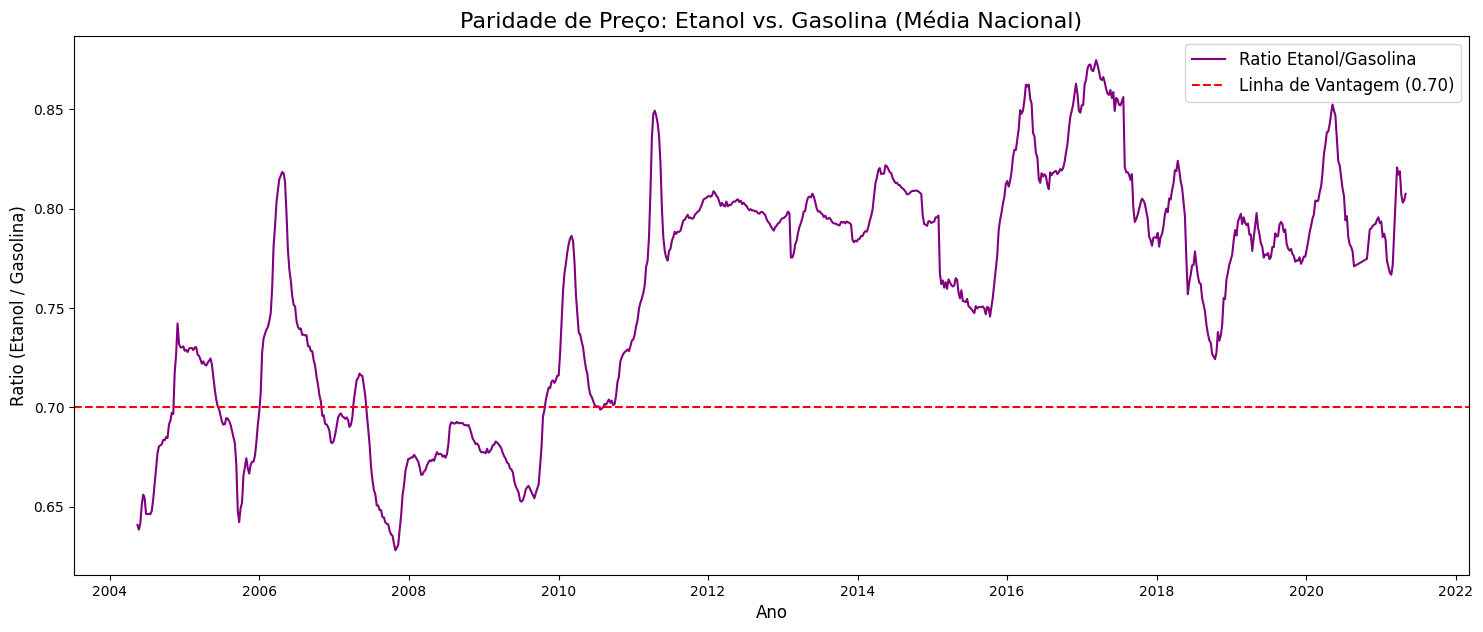

In [92]:
# Calculando o ratio
df_pivot_l['RATIO_ETANOL_GASOLINA'] = df_pivot_l['ETANOL HIDRATADO'] / df_pivot_l['GASOLINA COMUM']

# Plot do ratio
plt.figure(figsize=(18, 7))
plt.plot(df_pivot_l.index, df_pivot_l['RATIO_ETANOL_GASOLINA'], label='Ratio Etanol/Gasolina', color='purple')

# linha de referência de 70%
plt.axhline(0.70, color='red', linestyle='--', label='Linha de Vantagem (0.70)')

plt.title('Paridade de Preço: Etanol vs. Gasolina (Média Nacional)', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Ratio (Etanol / Gasolina)', fontsize=12)
plt.legend(fontsize=12)
plt.show()

Podemos observar que, depois de 2010, a vantagem da gasolina foi unânime.

## Análise Geográfica

Agora vamos iniciar as análises geográficas, com análises que envolvem preço médio por região e estado, e evoluções temporais por região.

Iniciando pelo valor médio de revenda para cada região. Iniciando para todos os tipos, dopois focando em apenas que utilizam ``R$/l``.

C:\Users\joabm\AppData\Local\Temp\ipykernel_14328\2756376669.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_regiao.values, y=media_regiao.index, palette='plasma')


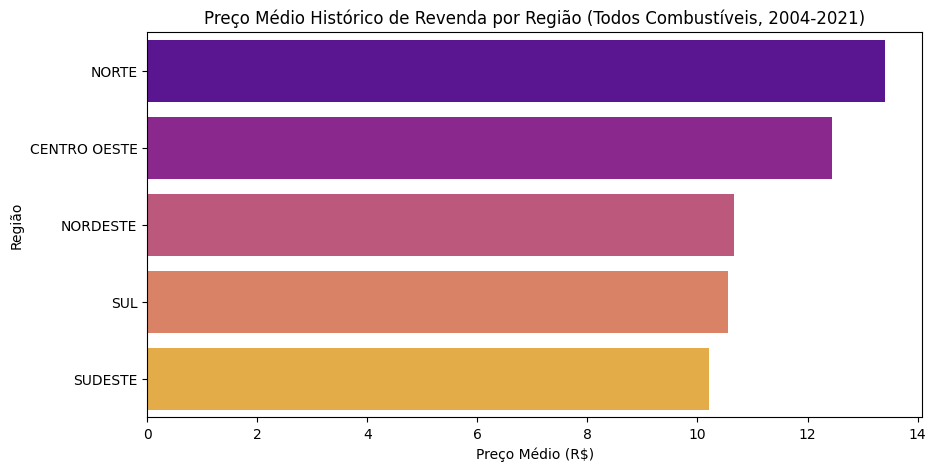

In [93]:
# Preço médio de revenda por Região
media_regiao = df.groupby('REGIÃO')['PREÇO MÉDIO REVENDA'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=media_regiao.values, y=media_regiao.index, palette='plasma')
plt.title('Preço Médio Histórico de Revenda por Região (Todos Combustíveis, 2004-2021)')
plt.xlabel('Preço Médio (R$)')
plt.ylabel('Região')
plt.show()

C:\Users\joabm\AppData\Local\Temp\ipykernel_14328\3917359778.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_regiao.values, y=media_regiao.index, palette='plasma')


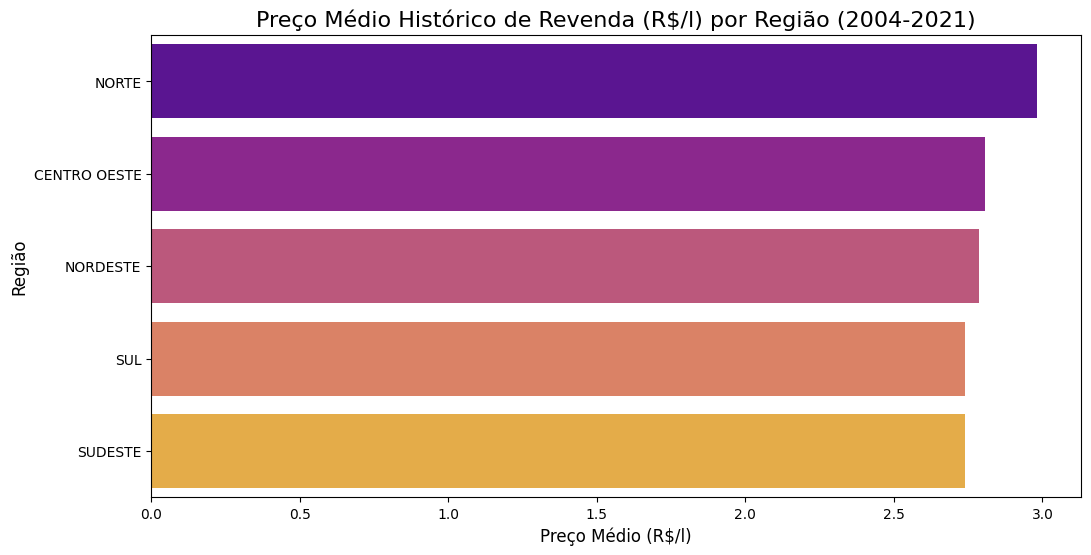

In [94]:
# preço médio de revenda (R$/l) por Região
df_litro = df_clean[df_clean['UNIDADE DE MEDIDA'] == 'R$/l'].copy()
media_regiao = df_litro.groupby('REGIÃO')[coluna_de_preco].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=media_regiao.values, y=media_regiao.index, palette='plasma')
plt.title('Preço Médio Histórico de Revenda (R$/l) por Região (2004-2021)', fontsize=16)
plt.xlabel('Preço Médio (R$/l)', fontsize=12)
plt.ylabel('Região', fontsize=12)
plt.show()

Podemos observar que o gráfico apresenta a mesma tendência para ambos os casos, onde a região Norte apresenta o preço médio mais caro do país. Isso é plausível e esperado, devido aos maiores custos logísticos. Em contrapartida, Sul e Sudeste apresentam os preços médios mais baixos. Isso se justifica pela concentração da infraestrutura. Podemos pensar pelo ponto de vista de oferta e demanda, mas esta é uma análise mais elaborada, em que devemos calcular o número de postos por pessoa de cada região.

Para uma análise mais micro (mas não tanto), vamos agora focar em cada UF.

C:\Users\joabm\AppData\Local\Temp\ipykernel_14328\3729247612.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_uf_recente.values, y=media_uf_recente.index, palette='mako')


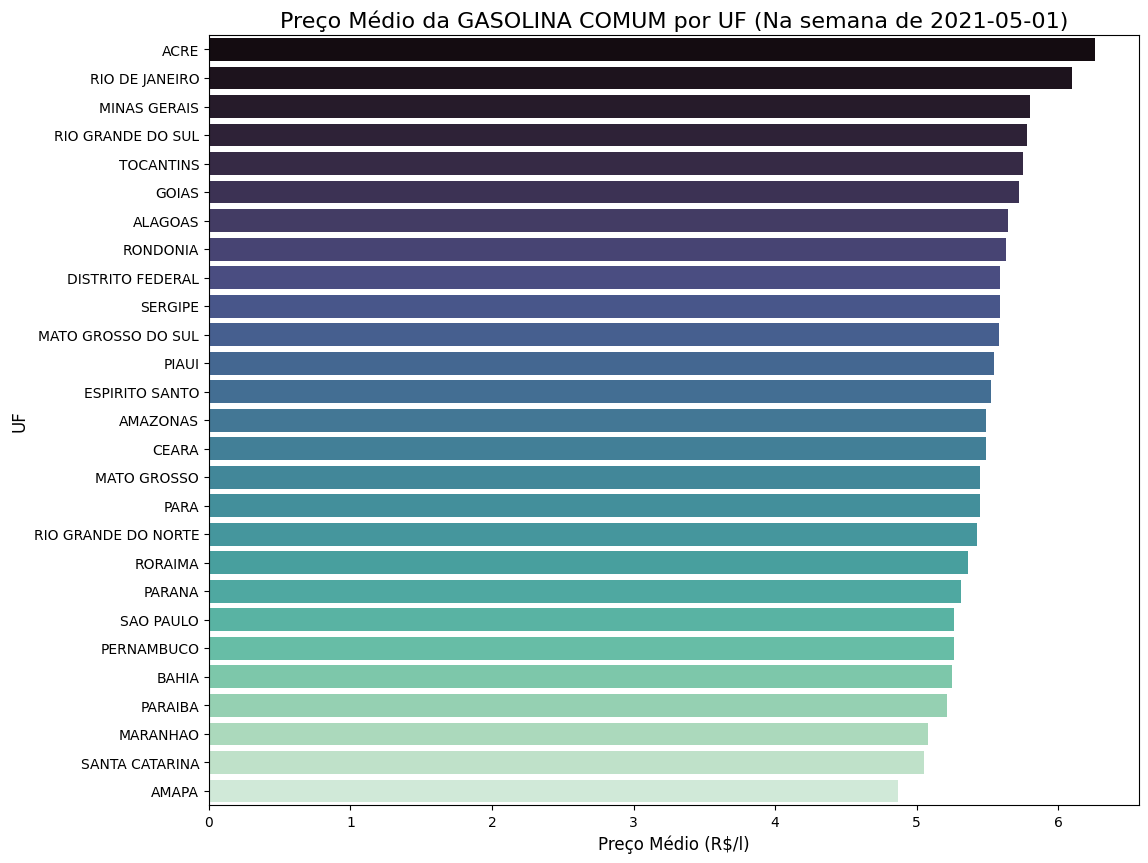

In [95]:
# Filtro para a data mais recente
data_recente = df_litro['DATA FINAL'].max()
df_recente = df_litro[
    (df_litro['DATA FINAL'] == data_recente) &
    (df_litro['PRODUTO'] == 'GASOLINA COMUM')
]

# fazendo a média por estado e ordenando
media_uf_recente = df_recente.groupby('ESTADO')[coluna_de_preco].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(x=media_uf_recente.values, y=media_uf_recente.index, palette='mako')
plt.title(f'Preço Médio da GASOLINA COMUM por UF (Na semana de {data_recente.strftime("%Y-%m-%d")})', fontsize=16)
plt.xlabel('Preço Médio (R$/l)', fontsize=12)
plt.ylabel('UF', fontsize=12)
plt.show()

Podemos observar que, embora no macro, o Sul e o Sudeste tenham, em média, o menor preço médio de combustível, podemos identificar alguns estados dessas regiões que estão no topo da lista.

Como antes analisamos o valor médio nacional do combustível, agora vamos escolher um combustível e analisar o valor médio regional e a sua evolução temporal.

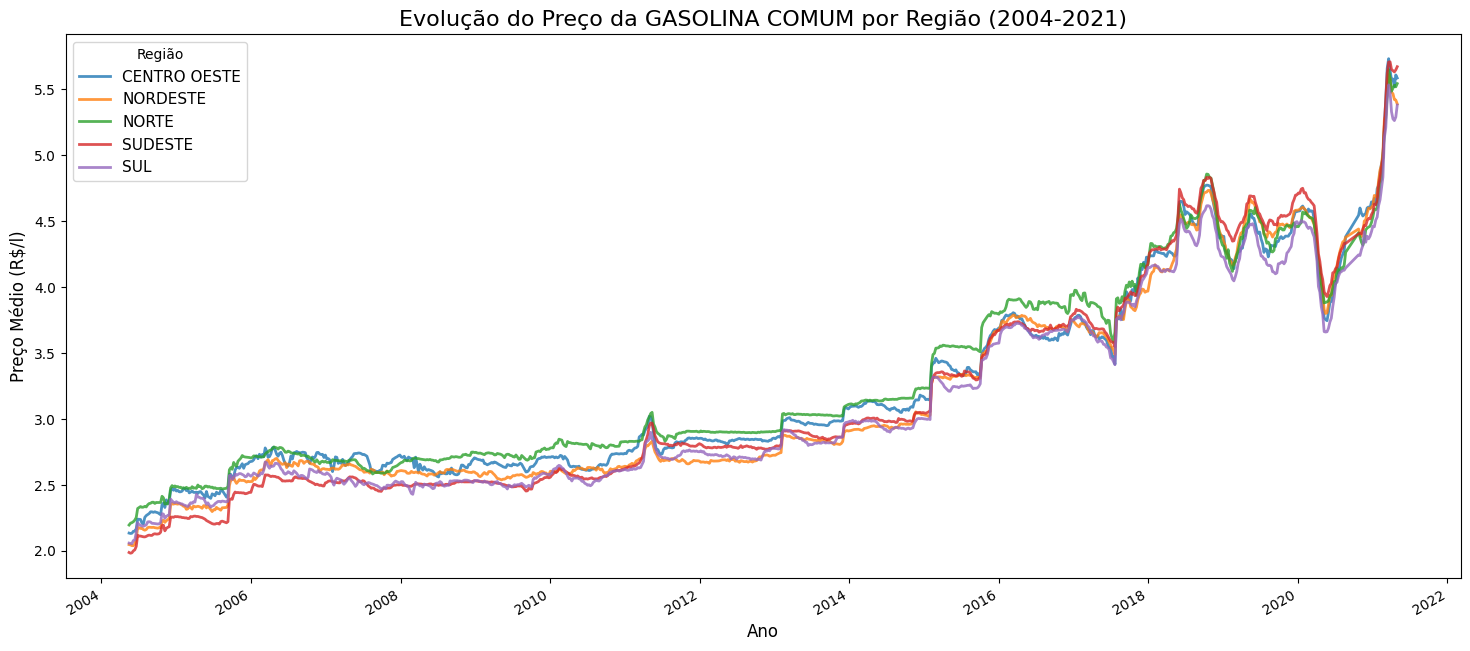

In [96]:
# Agrupar por data e região (apenas Gasolina)
df_gasolina = df_litro[df_litro['PRODUTO'] == 'GASOLINA COMUM']
df_regiao_temporal = df_gasolina.groupby(['DATA FINAL', 'REGIÃO'])[coluna_de_preco].mean().unstack()

# Plotar
plt.figure(figsize=(18, 8))
df_regiao_temporal.plot(ax=plt.gca(), linewidth=2, alpha=0.8)

plt.title('Evolução do Preço da GASOLINA COMUM por Região (2004-2021)', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Preço Médio (R$/l)', fontsize=12)
plt.legend(title='Região', fontsize=11)
plt.show()

Onde podemos novamente constatar que a região norte possui o maior valor para o preço da gasolina.

Agora, para fins de visualização, mais uma ferramenta que traz o gráfico da sobreposição da evolução temporal para um dado combustível em um determinado ano.

Filtrando dados para PRODUTO='GASOLINA COMUM' e ANO='2021'...
Dados filtrados. 486 linhas encontradas.
Iniciando a geração do gráfico...


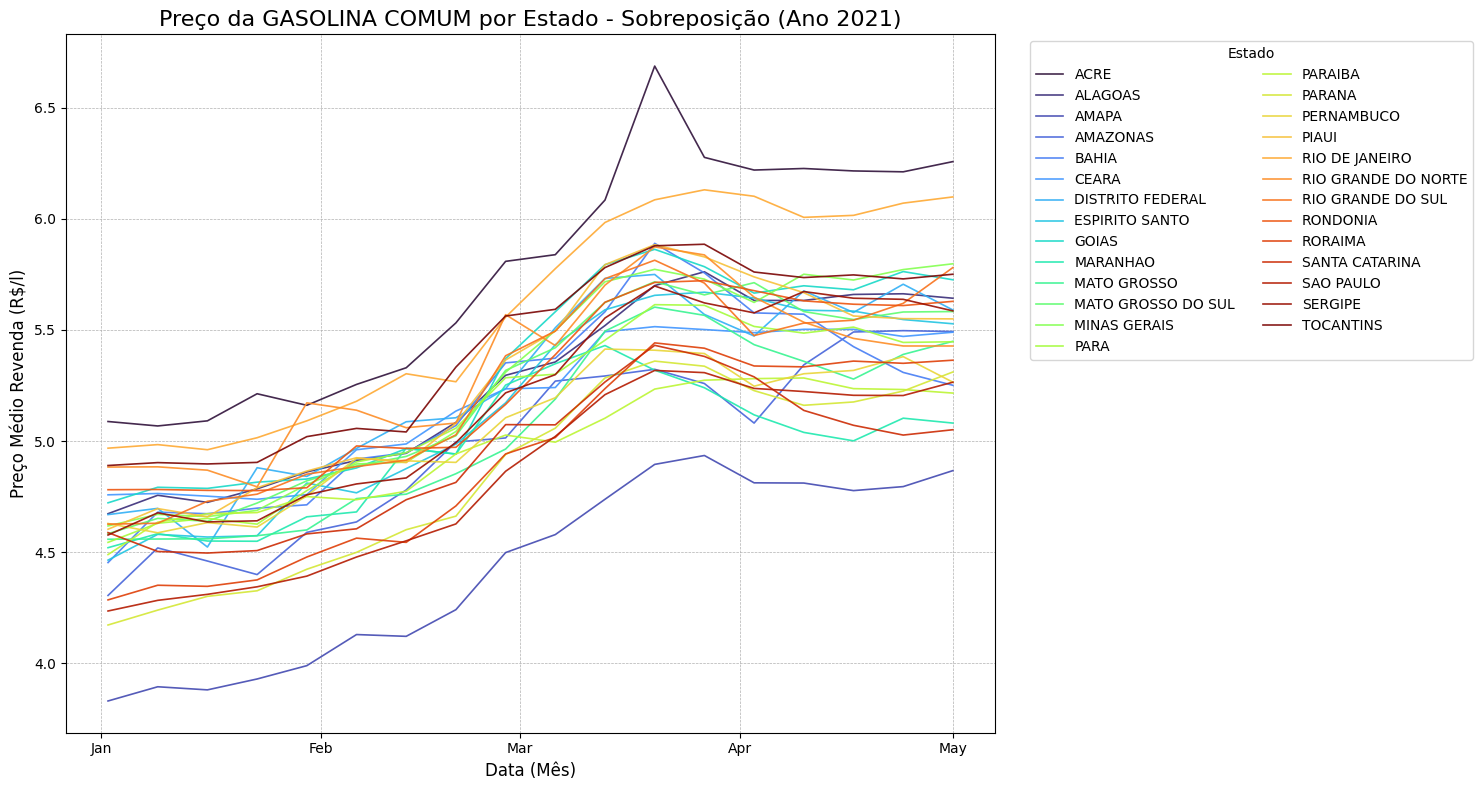

In [97]:
produto_alvo = 'GASOLINA COMUM'
ano_alvo = 2021

print(f"Filtrando dados para PRODUTO='{produto_alvo}' e ANO='{ano_alvo}'...")

df_filtrado = df[
    (df['PRODUTO'] == produto_alvo) &
    (df['DATA FINAL'].dt.year == ano_alvo)
].copy() 

if df_filtrado.empty:
    print(f"Nenhum dado encontrado para {produto_alvo} em {ano_alvo}.")
else:
    print(f"Dados filtrados. {len(df_filtrado)} linhas encontradas.")
    
    
    print("Iniciando a geração do gráfico...")
    plt.figure(figsize=(15, 8))
    ax = plt.gca()

    # Identificando todos os estados únicos e ordená-los
    estados_unicos = sorted(df_filtrado['ESTADO'].unique())
    n_estados = len(estados_unicos)
    
    # Criando um colormap
    colors = cm.turbo(np.linspace(0, 1, n_estados))

    # Loop para plotar uma linha para cada estado
    for i, estado in enumerate(estados_unicos):
        df_estado = df_filtrado[df_filtrado['ESTADO'] == estado].sort_values(by='DATA FINAL')
        
        ax.plot(
            df_estado['DATA FINAL'], 
            df_estado['PREÇO MÉDIO REVENDA'], 
            label=estado,
            color=colors[i],
            linewidth=1.2,
            alpha=0.9
        )

    # Plot
    ax.set_title(f'Preço da {produto_alvo} por Estado - Sobreposição (Ano {ano_alvo})', fontsize=16)
    ax.set_xlabel('Data (Mês)', fontsize=12)
    ax.set_ylabel('Preço Médio Revenda (R$/l)', fontsize=12)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

    ax.legend(title='Estado', bbox_to_anchor=(1.03, 1), loc='upper left', ncol=2)
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()

## Análise da Amostra

Agora vamos entender a confiabilidade dos dados. Para isso, vamos plotar a quantidade de postos por UF e por região, e analisar o quanto isso pode influenciar na nossa análise

C:\Users\joabm\AppData\Local\Temp\ipykernel_14328\2248139209.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_postos_uf.values, y=media_postos_uf.index, palette='rocket')


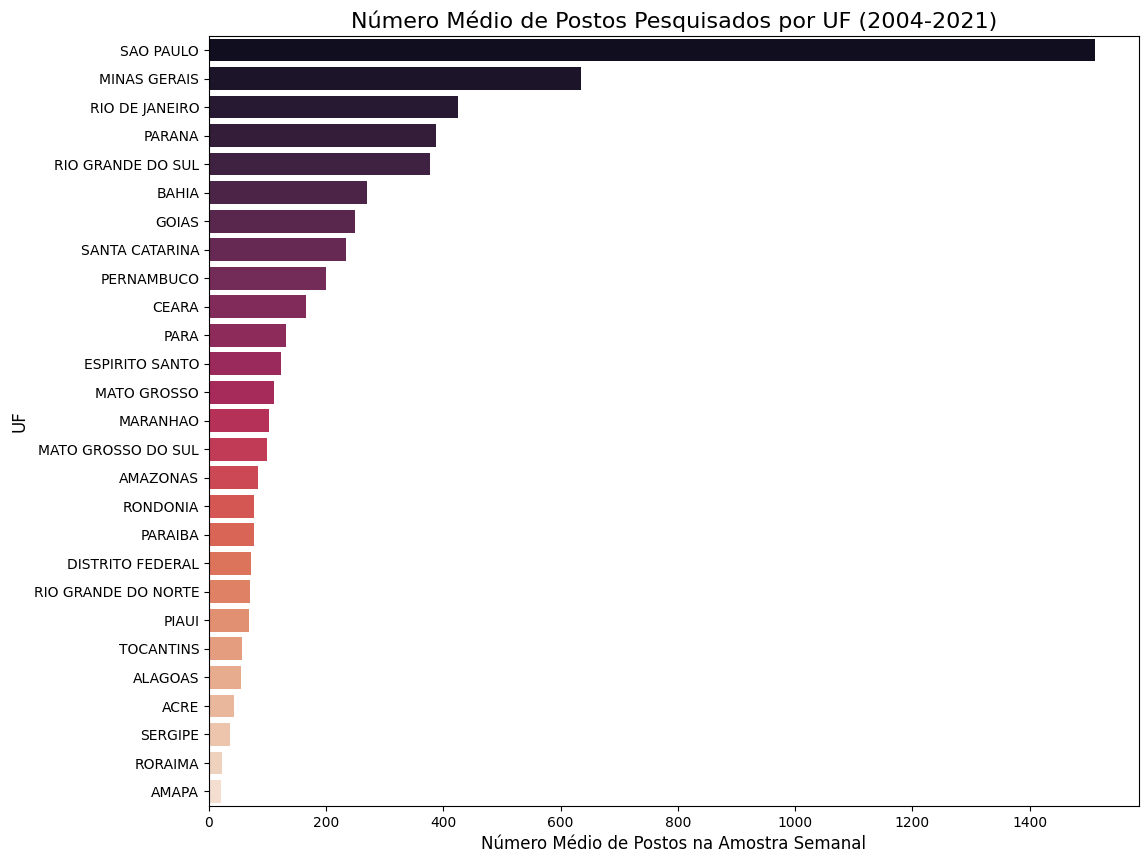

In [98]:
# Usar o dataframe limpo (antes do filtro R$/l) para incluir todos os postos
media_postos_uf = df_clean.groupby('ESTADO')['NÚMERO DE POSTOS PESQUISADOS'].mean().sort_values(ascending=False)

# Plotar
plt.figure(figsize=(12, 10))
sns.barplot(x=media_postos_uf.values, y=media_postos_uf.index, palette='rocket')
plt.title('Número Médio de Postos Pesquisados por UF (2004-2021)', fontsize=16)
plt.xlabel('Número Médio de Postos na Amostra Semanal', fontsize=12)
plt.ylabel('UF', fontsize=12)
plt.show()

Limpeza das colunas relevantes concluída.

Número médio de postos pesquisados por semana (por Região):
REGIÃO
SUDESTE         673.675402
SUL             332.741900
CENTRO OESTE    130.911055
NORDESTE        117.176934
NORTE            62.700239
Name: NÚMERO DE POSTOS PESQUISADOS, dtype: float64

Gerando gráfico...


C:\Users\joabm\AppData\Local\Temp\ipykernel_14328\1742741776.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


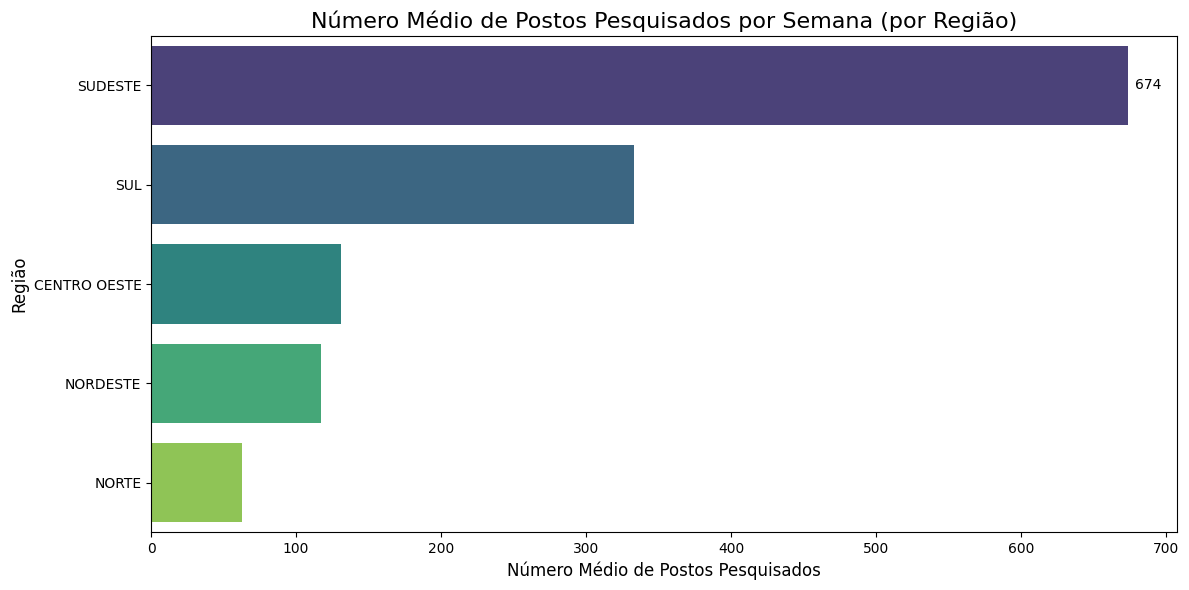

In [99]:
col_postos = 'NÚMERO DE POSTOS PESQUISADOS'
col_grupo = 'REGIÃO'

df_clean = df.dropna(subset=[col_postos, col_grupo])
print("Limpeza das colunas relevantes concluída.")

media_postos_regiao = df_clean.groupby(col_grupo)[col_postos].mean().sort_values(ascending=False)

print("\nNúmero médio de postos pesquisados por semana (por Região):")
print(media_postos_regiao)

# plot

print("\nGerando gráfico...")
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x=media_postos_regiao.values, 
    y=media_postos_regiao.index, 
    palette='viridis'
)

plt.title('Número Médio de Postos Pesquisados por Semana (por Região)', fontsize=16)
plt.xlabel('Número Médio de Postos Pesquisados', fontsize=12)
plt.ylabel('Região', fontsize=12)

# Adicionar os valores nas barras (opcional, mas bom)
ax.bar_label(ax.containers[0], fmt='%.0f', padding=5)

plt.tight_layout()

Podemos observar a discrepância do número de postos nas regiões Sul e Sudeste. As médias de estados com poucos postos são muito voláteis e, consequentemente, menos confiáveis do que a média de São Paulo, do ponto de vista estatístico.

## Relatório de Análise

Dentre as análises, podemos destacar algumas. A primeira é aquela que, à primeira vista, influencia diretamente o cliente final dos combustíveis mais comuns: a paridade de preço. Esta mostra o quão vantajoso um combustível é sobre o outro, levando em conta o rendimento de cada um. Esse tipo de análise pode ser generalizado a ponto de influenciar decisões em níveis empresariais, como a decisão de investimentos em frotas de carros, onde, à primeira vista, investir em carros flex por economia não seja tão vantajoso, já que a gasolina tem um rendimento superior por preço.

A segunda análise refere-se à busca por sazonalidade nos diferentes tipos de combustíveis, tanto em nível nacional quanto regional ou estadual. Compreender os períodos mais prováveis de altas e baixas de preços pode ser crucial para a tomada de decisão, permitindo antecipar movimentos do mercado e adotar estratégias mais eficientes.

A terceira análise refere-se à tendência da dinâmica dos preços. Além da periodicidade sazonal, compreender essa tendência é fundamental, pois permite realizar previsões futuras e identificar possíveis direções do mercado. Essa compreensão auxilia na formulação de estratégias de compra, venda ou regulação mais assertivas.

A quarta análise, pouco explorada neste trabalho, busca compreender o epicentro das tendências, ou seja, identificar se alguma região tende a apresentar um comportamento antecipado em relação às demais. Caso esse padrão seja confirmado, essa região pode ser utilizada como referência estratégica em processos de tomada de decisão, permitindo prever movimentações de preço em outras localidades.


A partir dessas análises, podemos extrair algumas conclusões. Observa-se que a tendência geral das dinâmicas de preço de todos os combustíveis aponta para um aumento consistente no longo prazo. Essa elevação pode estar relacionada a fatores como inflação, custos de produção e variações nas relações internacionais.

No que diz respeito à sazonalidade, o combustível analisado (neste caso, o etanol) apresenta um comportamento fortemente sazonal e previsível, refletindo padrões recorrentes ao longo do tempo.

Em relação à paridade de preços, verifica-se a desvantagem do etanol em comparação à gasolina, mesmo apresentando um preço médio inferior, o que evidencia limitações competitivas do produto em determinadas condições de mercado.

Por fim, quanto ao epicentro de eventos, observa-se que todas as regiões tendem a variar suas taxas de forma relativamente uniforme, sem a presença de um epicentro claramente identificado. Isso indica que as oscilações de preço ocorrem de maneira sincronizada entre as diferentes localidades analisadas.

Quanto às observações geográficas, nota-se que a Região Norte é, de forma consistente, a área com o combustível mais caro do Brasil, provavelmente em razão dos custos logísticos de distribuição e das dinâmicas locais de oferta e demanda. Em contrapartida, as Regiões Sudeste e Sul apresentam os menores preços médios.

Além disso, observa-se que as tendências de preço são convergentes, ou seja, todas as regiões apresentam elevações e quedas de forma sincronizada, refletindo uma resposta conjunta às variações do mercado nacional.


Com relação às limitações, podem ser destacadas duas principais: viés da amostra e falta de dados externos. A análise do número de postos pesquisados revelou uma disparidade significativa entre as regiões. A coleta de dados é fortemente concentrada no Sudeste, enquanto estados da Região Norte apresentam uma amostragem semanal reduzida, tornando as médias estaduais desses locais estatisticamente menos confiáveis e mais voláteis. Além disso, esta investigação teve caráter puramente exploratório, baseada apenas no arquivo de dados fornecido. As possíveis correlações com eventos externos (como greves ou a pandemia de COVID-19) devem ser interpretadas apenas como inferências preliminares. Para validar relações de causalidade, seria necessário cruzar essas informações com outras séries temporais e variáveis explicativas.

Para os próximos passos, propõe-se a realização de modelagem e análise de correlação, seguida da modelagem preditiva utilizando modelos de inteligência artificial aplicados à regressão. Esses estudos poderão proporcionar um maior aprofundamento na compreensão da dinâmica econômica, tanto em nível macroeconômico quanto microeconômico, contribuindo para análises mais robustas.